In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ssmdm.models import Accumulator2D, DDM, Accumulator2DTransitions, Accumulator2DObservations
from ssmdm.misc import generate_clicks, factor_analysis
from ssm.emissions import _LinearEmissions, GaussianEmissions, PoissonEmissions
from ssm.core import BaseSwitchingLDS
from ssm.util import ensure_args_are_lists
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import _Transitions, RecurrentOnlyTransitions
from ssm.observations import _Observations, AutoRegressiveDiagonalNoiseObservations

# preprocessing
from ssm.preprocessing import factor_analysis_with_imputation
from tqdm.auto import trange

# for initialization
from ssm.optimizers import adam_step, rmsprop_step, sgd_step, convex_combination
from autograd.scipy.misc import logsumexp
from autograd.tracer import getval
from autograd.misc import flatten
from autograd import value_and_grad

**Create model and generate data**

To do:
1) change DMGaussianEmissions to be one function that maps latents to observations. the only key difference is the initialization. have it take in the latent model ( e.g. DDM(), Accumulator2D(), as an input ! ). then use that in the initialization objective. the goal is to have this work for different models. 

In [102]:
# Transition model V2
from ssm.transitions import RecurrentOnlyTransitions
class Accumulator2DTransitions(RecurrentOnlyTransitions):
    def __init__(self, K, D, M=0, scale=50):
        assert K == 3
        assert D == 2
        assert M == 2
        super(Accumulator2DTransitions, self).__init__(K, D, M)
        
        self.Ws = np.zeros((K,M))
#         self.Rs = np.array([[scale, 0], [0, 0], [0, scale]]).reshape((K,D)) # K by D
        self.Rs = np.array([[scale, -scale], [0, 0], [-scale, scale]]).reshape((K,D)) # K by D
        self.r = np.array([-scale, 0, -scale])
        
    @property
    def params(self):
        return ()
    
    @params.setter
    def params(self, value):
        pass
    
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass
    
    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        pass

In [103]:
class Acc2DGaussianEmissions(GaussianEmissions):
    def __init__(self, N, K, D, M=0, single_subspace=True):
        super(Acc2DGaussianEmissions, self).__init__(N, K, D, M=M, single_subspace=single_subspace)
        # Make sure the input matrix Fs is set to zero and never updated
        self.Fs *= 0
        
    # Construct an emissions model
    @property
    def params(self):
#         return self._Cs, self.ds, self.inv_etas
        return self._Cs, self.ds

    @params.setter
    def params(self, value):
#         self._Cs, self.ds, self.inv_etas = value
        self._Cs, self.ds = value

    def initialize(self, datas, inputs=None, masks=None, tags=None, num_em_iters=50, num_tr_iters=50):

        print("Initializing...")
        print("First with FA using {} steps of EM.".format(num_em_iters))
        fa, xhats, Cov_xhats, lls = factor_analysis_with_imputation(self.D, datas, masks=masks, num_iters=num_em_iters)
        
        # define objective
        def _objective(params, itr):
            Td = sum([x.shape[0] for x in xhats])
            new_datas = [np.dot(x,params[0].T)+params[1] for x in xhats]
            obj = Accumulator2D().log_likelihood(new_datas,inputs=inputs)
            return -obj / Td
        
        # initializeR and r
        R = 0.1*np.random.randn(self.D,self.D)
        r = 0.1*np.random.randn(self.D)
        params = [R,r]
        Td = sum([x.shape[0] for x in xhats])
        
        print("Next by transforming latents to match DDM prior using {} steps of max log likelihood.".format(num_tr_iters))

        state = None
        lls = [-_objective(params, 0) * Td]
        pbar = trange(num_tr_iters)
        pbar.set_description("Epoch {} Itr {} LP: {:.1f}".format(0, 0, lls[-1]))

        for itr in pbar:
            params, val, g, state = sgd_step(value_and_grad(_objective), params, itr, state)
            lls.append(-val * Td)
            pbar.set_description("LP: {:.1f}".format(lls[-1]))
            pbar.update(1)
    
        R = params[0]
        r = params[1]
        
        self.Cs = (fa.W @ np.linalg.inv(R)).reshape([1,self.N,self.D])
        self.ds = fa.mean - fa.W @ np.linalg.inv(R) @ r
        self.inv_etas = np.log(fa.sigmasq)
        
def LatentAccumulator2D(N, betas=np.ones(2,), sigmas=1e-3 * np.ones((3, 2)), a_diag=np.ones((3,2,1))):
    K, D, M = 3, 2, 2
    
    # Build the initial state distribution, the transitions, and the observations
    init_state_distn = InitialStateDistribution(K, D, M)
    init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
    transition_distn = Accumulator2DTransitions(K, D, M)
    dynamics_distn = Accumulator2DObservations(K, D, M, betas=betas, sigmas=sigmas, a_diag=a_diag)
    
    # add in Poisson here... 
    emission_distn = Acc2DGaussianEmissions(N, K, D, M=M, single_subspace=True)

    return BaseSwitchingLDS(N, K, D, M, init_state_distn, transition_distn, dynamics_distn, emission_distn)

In [104]:
# create 2D accumulator

sigmas = np.array([[2e-4,1e-4],[3e-4,5e-4],[1e-4,2e-4]])
betas = np.array([1.0,1.0])
a_diag = np.ones((3,2,1))
# a_diag[1,:,0] = np.array([0.99,0.98])
acc2 = Accumulator2D(sigmas=sigmas,betas=betas,a_diag=a_diag)

# Sample state trajectories
T = 100 # number of time bins
trial_time = 1.0 # trial length in seconds
dt = 0.01 # bin size in seconds
N_samples = 40 

# input statistics
total_rate = 40 # the sum of the right and left poisson process rates is 40

us = []
zs = []
xs = []

for smpl in range(N_samples):

    # randomly draw right and left rates
    rate_r = np.random.randint(0,total_rate+1)
#     rate_r = np.random.choice(np.append(np.arange(11),np.arange(30,41,1)))
    rate_l = total_rate - rate_r

    # generate binned right and left clicks
    u_r, u_l = generate_clicks(T=trial_time,dt=dt,rate_r=rate_r,rate_l=rate_l)
    
    # input is sum of u_r and u_l
    u = 0.1*np.array([u_r,u_l]).T
    z, x = acc2.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

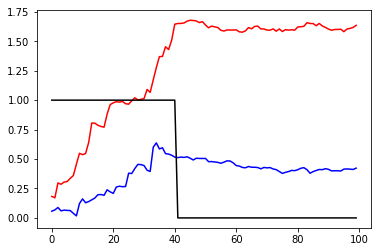

In [124]:
# tr = 0
tr+=1
plt.figure()
plt.plot(xs[tr][:,0],'r')
plt.plot(xs[tr][:,1],'b')
plt.plot(zs[tr],'k')

In [126]:
# generate data
N = 10
D = 2
C = np.random.randn(N, D)
ys = [np.dot(x, C.T) + np.arange(0.5,1.5,0.1) + .01 * np.random.randn(T, N) for x in xs]

**Initialize model**

In [245]:
latent_acc = LatentAccumulator2D(N)

In [246]:
# masks = [np.random.rand(T,N) < 0.9 for y in ys]
masks = [np.reshape(np.arange(0,T,1),[T,1])@np.ones([1,N]) > 98 for y in ys]
y_masked = [mask * y for mask, y in zip(masks,ys)]

In [247]:
latent_acc.initialize(ys, inputs=us)
# latent_acc.initialize(y_masked, masks=masks, inputs=us)

Initializing...
First with FA using 50 steps of EM.


/Users/davidzoltowski/github/pybasicbayes/pybasicbayes/util/stats.py:184: RuntimeWarning: divide by zero encountered in true_divide
  return 1./np.random.gamma(alpha, 1./beta)


Next by transforming latents to match DDM prior using 50 steps of max log likelihood.


/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Initializing with an ARHMM using 25 steps of EM.


/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  onp.add.at(A, idx, x)
/Users/davidzoltowski/github/ssm/ssm/optimizers.py:130: UserWarning: BFGS failed with message:
Maximum number of iterations has been exceeded.
  warn("{} failed with message:\n{}".format(method, result.mes

In [134]:
print(latent_acc.emissions.inv_etas)
print(latent_acc.emissions.ds)
print(np.log(0.0001))

[-9.21260373 -9.04579879 -9.02178455 -9.50395422 -9.11660858 -8.21365437
 -9.12525098 -9.18141313 -9.13603149 -8.52236225]
[0.60504557 0.74966495 0.84713008 0.73332079 0.88657114 1.10911685
 1.06816374 1.20690298 1.22119025 1.54923828]
-9.210340371976182


**Look at initialization results!**

Text(0.5,1,'FA+Init C')

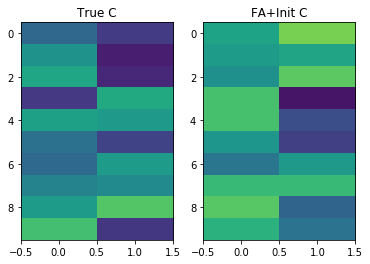

In [203]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(C,aspect='auto')
plt.clim([-2.5,2.5])
plt.title('True C')
plt.subplot(1,2,2)
plt.imshow(latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title('FA+Init C')

**Initialize variational posterior**

In [249]:
# Create a variational posterior
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
# q_mf = SLDSMeanFieldVariationalPosterior(latent_acc2, ys, inputs=us)
q_mf = SLDSMeanFieldVariationalPosterior(latent_acc, y_masked, inputs=us,  masks=masks)

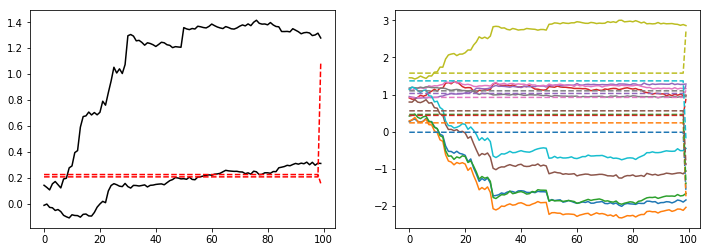

In [251]:
tr = 0
# tr += 1
yhat = latent_acc.smooth(q_mf.mean[tr], ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr],'k')
plt.plot(q_mf.mean[tr],'r--')
plt.subplot(1,2,2)
plt.plot(ys[tr])
plt.plot(yhat, '--')

**Fit model**

In [223]:
# what parameters does it have? 
# latent_acc.init_state_distn.log_pi0 # initial state distribution
# latent_acc.dynamics._betas # mapping from input to latents
# latent_acc.dynamics._log_sigmasq # dynamics (diagonal) covariance
# latent_acc.dynamics._As # dynamics
# latent_acc.emissions.Cs # emissions matrix
# latent_acc.emissions.ds # emissions mean
# latent_acc.emissions.inv_etas # emissions log variance?

In [252]:
# q_mf_elbos = latent_acc.fit(q_mf, ys, inputs=us, method="svi", num_iters=100, initialize=False)
q_mf_elbos = latent_acc.fit(q_mf, y_masked, masks=masks, inputs=us, method="svi", num_iters=100, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


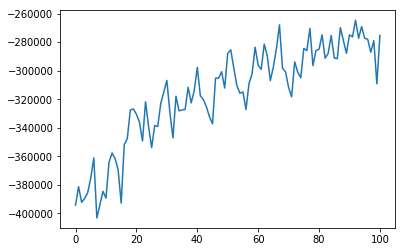

In [253]:
plt.plot(q_mf_elbos)

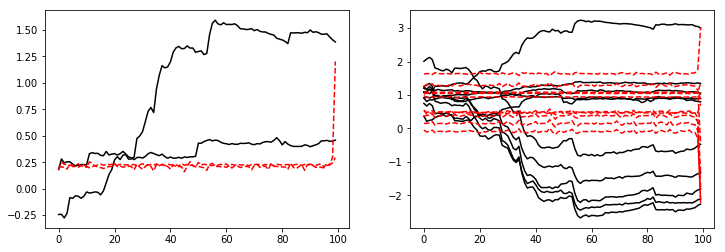

In [281]:
tr = 0
tr += 1 
# yhat = latent_acc.smooth(q_mf.mean[tr], ys[tr], input=us[tr])
yhat = latent_acc.smooth(q_mf.mean[tr], y_masked[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr],'k')
plt.plot(q_mf.mean[tr],'r--')
plt.subplot(1,2,2)
plt.plot(ys[tr],'k')
plt.plot(yhat, 'r--')
# plt.plot(np.dot(q_mf.mean[tr],latent_acc2.emissions.Cs[0,:,:].T)+latent_acc2.emissions.ds,'b--')


<Figure size 432x288 with 0 Axes>

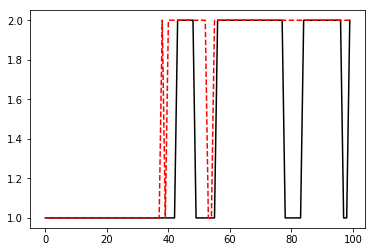

In [173]:
# tr = 0
tr +=1 
plt.figure()
zhat = latent_acc.most_likely_states(q_mf.mean[tr], ys[tr], input=us[tr])
plt.figure()
plt.plot(zs[tr],'k')
plt.plot(zhat,'r--')

**Compare fit params**

In [283]:
print("Dynamics: ", acc2.observations.As)
print("Beta: ", acc2.observations._betas)
print("Sigma: ", acc2.observations._log_sigmasq)

Dynamics:  [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Beta:  [1. 1.]
Sigma:  [[-8.51719319 -9.21034037]
 [-8.11172808 -7.60090246]
 [-9.21034037 -8.51719319]]


In [284]:
print("Dynamics: ", latent_acc.dynamics.As)
print("Beta: ", latent_acc.dynamics._betas)
print("Sigma: ", latent_acc.dynamics._log_sigmasq)

Dynamics:  [[[0.92701165 0.        ]
  [0.         0.97279882]]

 [[0.91130163 0.        ]
  [0.         0.91071798]]

 [[0.93421234 0.        ]
  [0.         0.93376349]]]
Beta:  [0.87629848 0.82029794]
Sigma:  [[-8.35068195 -9.12117137]
 [-7.83691283 -7.65503798]
 [-8.94481306 -8.57816598]]


Text(0.5,1,'FA+Init C')

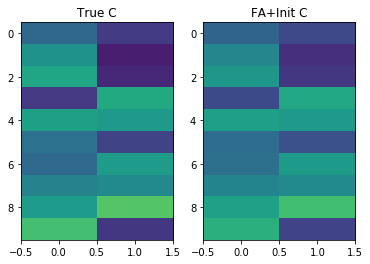

In [165]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(C,aspect='auto')
plt.clim([-2.5,2.5])
plt.title('True C')
plt.subplot(1,2,2)
plt.imshow(latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title('FA+Init C')

In [169]:
print("ds: ",latent_acc.emissions.ds)
print(np.arange(0.5,1.5,0.1))

ds:  [0.17665367 0.34277753 0.51328512 0.62830589 0.97544757 0.72150041
 1.01498659 1.143484   1.48421422 1.32851883]
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]


array([[0., 0.],
       [0., 0.],
       [0., 0.]])

**Try variational EM**

In [ ]:
latent_acc2 = LatentAccumulator2D(N)
latent_acc2.initialize(ys, inputs=us)

In [ ]:
# Create a variational posterior
from ssm.variational import SLDSMeanFieldVariationalPosterior
q_mf2 = SLDSMeanFieldVariationalPosterior(latent_acc2, ys, inputs=us, initial_variance=0.01)

q_mf_elbos2 = latent_acc2.fit(q_mf2, ys, inputs=us, method="vem", initialize=False)

# Get the posterior mean of the continuous states
q_mf_x2 = q_mf2.mean[0]

In [ ]:
plt.plot(q_mf_elbos2)

In [ ]:
# tr = 0
tr += 1 
yhat = latent_acc2.smooth(q_mf2.mean[tr], ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr],'k')
plt.plot(q_mf2.mean[tr],'r--')
plt.subplot(1,2,2)
plt.plot(ys[tr])
plt.plot(yhat, '--')

In [ ]:
print("Dynamics: ", acc2.observations.As)
print("Beta: ", acc2.observations._betas)
print("Sigma: ", acc2.observations._log_sigmasq)

In [ ]:
print("Dynamics: ", latent_acc2.dynamics.As)
print("Beta: ", latent_acc2.dynamics._betas)
print("Sigma: ", latent_acc2.dynamics._log_sigmasq)

**Tridiagonal posterior**

In [840]:
from ssm.variational import SLDSTriDiagVariationalPosterior

q = SLDSTriDiagVariationalPosterior(latent_acc, ys, inputs=us)
elbos = latent_acc.fit(q, ys, inputs=us, num_iters=5000, initialize=False)

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


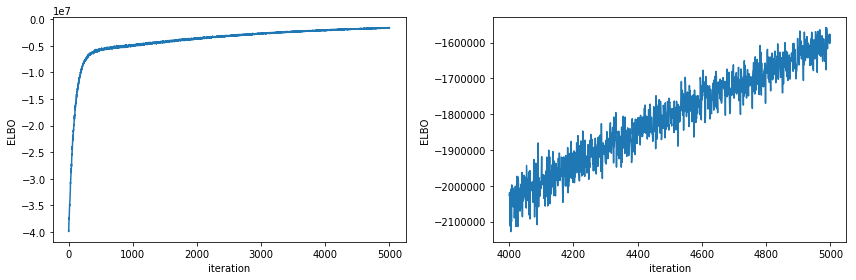

In [841]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(elbos)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.subplot(1,2,2)
plt.plot(np.arange(4000,5000),elbos[4001:])
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.tight_layout()

In [842]:
print("Dynamics: ", acc2.observations.As)
print("Beta: ", acc2.observations._betas)
print("Sigma: ", acc2.observations._log_sigmasq)

Dynamics:  [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Beta:  [1. 1.]
Sigma:  [[-8.51719319 -9.21034037]
 [-8.11172808 -7.60090246]
 [-9.21034037 -8.51719319]]


In [843]:
print("Dynamics: ", latent_acc.dynamics.As)
print("Beta: ", latent_acc.dynamics._betas)
print("Sigma: ", latent_acc.dynamics._log_sigmasq)

Dynamics:  [[[0.9987635  0.        ]
  [0.         0.98299792]]

 [[0.99689359 0.        ]
  [0.         0.98320215]]

 [[0.96065424 0.        ]
  [0.         1.00233657]]]
Beta:  [1.07846394 1.47531025]
Sigma:  [[-4.6332431  -5.11679281]
 [-4.85466485 -6.31559696]
 [-5.74175794 -4.94132037]]


In [845]:
print("True emissions noise", np.log(.0001))
print("Inferred emissions noise", latent_acc.emissions.inv_etas)

True emissions noise -9.210340371976182
Inferred emissions noise [-9.22051639 -9.17062806 -9.2051152  -9.2115701  -9.20011954 -9.20836406
 -9.21114535 -9.19528279 -9.23041099 -9.21598156]


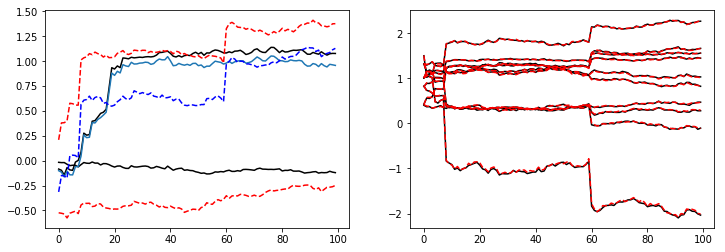

In [913]:
# tr = 0
tr += 1 
yhat = latent_acc.smooth(q.mean[tr], ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(xs[tr],'k')
# plt.plot(np.sum(xs[tr],axis=1))
plt.plot(q.mean[tr],'r--')
# plt.plot(np.sum(q.mean[tr],axis=1),'b--')
plt.subplot(1,2,2)
plt.plot(ys[tr],'k')
plt.plot(yhat, 'r--')

In [315]:
# np.savez('latent_acc_svi_tridiag',latent_acc=latent_acc,ys=ys,xs=xs,us=us,zs=zs,q=q,true_acc=acc2)

<Figure size 432x288 with 0 Axes>

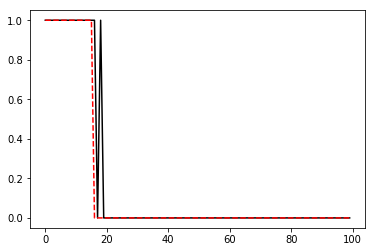

In [875]:
# tr = 0
tr +=1 
plt.figure()
zhat = latent_acc.most_likely_states(q.mean[tr], ys[tr], input=us[tr])
plt.figure()
plt.plot(zs[tr],'k')
plt.plot(zhat,'r--')

Text(0.5,1,'FA+Init C')

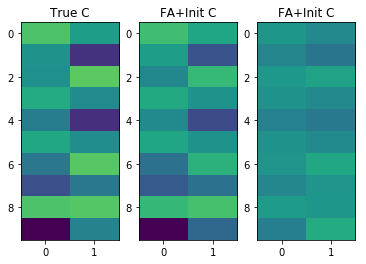

In [914]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(C,aspect='auto')
plt.clim([-2.5,2.5])
plt.title('True C')
plt.subplot(1,3,2)
plt.imshow(latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title('FA+Init C')
plt.subplot(1,3,3)
plt.imshow(C-latent_acc.emissions.Cs[0,:,:],aspect='auto')
plt.clim([-2.5,2.5])
plt.title('FA+Init C')